In [1]:
import numpy as np
import pandas as pd
import kagglehub
import datetime as dt
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
# from ydata_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.imputation import DropMissingData
from feature_engine.encoding import OneHotEncoder
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor


h:\VScode\PoliticalDonations\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Data

In [2]:
def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):
  """
  This function compares the distribution of variables before and after data cleaning.

  Parameters:
  df_original (DataFrame): The original DataFrame before cleaning.
  df_cleaned (DataFrame): The DataFrame after cleaning.
  variables_applied_with_method (list): The list of variables that the cleaning method was applied to.
  """

  flag_count=1 # Counter to keep track of the plot number
  
  # Identify categorical variables in the original DataFrame
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # Loop over the variables that the cleaning method was applied to
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  
    # For each variable, plot its distribution before and after cleaning
    for var in set_of_variables:
      if var in categorical_variables:  # If the variable is categorical, use a barplot
        # Create DataFrames for the original and cleaned data
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        # Concatenate the two DataFrames
        dfAux = pd.concat([df1, df2], axis=0)
        # Create the plot
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # If the variable is numerical, use a histogram
        # Create the plot
        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend()

In [4]:
def FeatureEngineeringAnalysis(df,analysis_type=None):


  """
  - used for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape 
  - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Loop over each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng, list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is missing values in your dataset. Please handle that before getting into feature engineering.")



def define_list_column_transformers(analysis_type):
  ### Set suffix colummns acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e","log_10","reciprocal", "power","box_cox","yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers



def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers



def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)
    
    else:
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")



def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(20, 5))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show();
  print("\n")



def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.show();


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=1.5, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked




def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

    ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)


  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked

In [2]:
df = pd.read_csv('Donations_accepted_by_political_parties.csv', dtype={
    'index': 'int64',
    'ECRef' : 'object',
    'RegulatedEntityName': 'object',
    'RegulatedEntityType': 'object',
    'Value': 'string',
    "AcceptedDate": 'string',
    "AccountingUnitName": 'string',
    "DonorName": 'object',
    "AccountingUnitsAsCentralParty": 'bool',
    'IsSponsorship': 'bool',
    'DonorStatus': 'object',
    'RegulatedDoneeType': 'object',
    'CompanyRegistrationNumber': 'string',
    'Postcode': 'string',
    'DonationType': 'object',
    'NatureOfDonation': 'object',
    'PurposeOfVisit': 'string',
    'DonationAction': 'string',
    'ReceivedDate': 'string',
    'ReportedDate': 'string',
    'IsReportedPrePoll': 'string',
    'ReportingPeriodName': 'string',
    'IsBequest': 'bool',
    'IsAggregation': 'bool',
    'RegulatedEntityId': 'object',
    'AccountingUnitId': 'string',
    'DonorId': 'object',
    'CampaigningName': 'string',
    'RegisterName': 'string',
    'IsIrishSource': 'string'
    },index_col="index")

# DataSummary
def DataSummary(dfTest):

    NonObject = dfTest.select_dtypes(exclude=['object', 'string', 'datetime64']).columns
    summary_df = pd.DataFrame({
        'DataType': dfTest.dtypes,
        'UniqueValues': dfTest.nunique(),
        'RowsWithData': len(dfTest)-dfTest.isnull().sum(),
        'NullValues':dfTest.isnull().sum(),
        'SkewScore':dfTest[NonObject].skew(),
        'Kurtosis':dfTest[NonObject].kurtosis()
    }).reset_index().rename(columns={'index': 'Column'})
    return summary_df

print(DataSummary(df))


                           Column        DataType  UniqueValues  RowsWithData  \
0                    AcceptedDate  string[python]          6265         64265   
1                AccountingUnitId  string[python]          2185         36355   
2              AccountingUnitName  string[python]          1856         56957   
3   AccountingUnitsAsCentralParty            bool             2         65278   
4                 CampaigningName  string[python]             3             5   
5       CompanyRegistrationNumber  string[python]          3558         11480   
6                  DonationAction  string[python]             3           283   
7                    DonationType          object             9         65278   
8                         DonorId          object         44739         65197   
9                       DonorName          object         19010         65193   
10                    DonorStatus          object            13         65220   
11                          

In [3]:
# Remove Currency sign of Value and convert to Float
df['Value'] = df['Value'].replace({'\£': '', ',': ''}, regex=True).astype(float)
# Fill blank ReceivedDate with ReportedDate
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['ReportedDate'])
# Fill blank ReceivedDate with AcceptedDate
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['AcceptedDate'])
# convert Received date to Date Format
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'], format='%d/%m/%Y', errors='coerce')
# Convert 'ReportingPeriodName' to datetime if it contains dates at the e
df['ReportingPeriodName_Date'] = pd.to_datetime(
    df['ReportingPeriodName'].str.strip().str[-10:],
    dayfirst=True,
    format='mixed', 
    errors='coerce'
)
# Fill missing 'ReceivedDate' with extracted dates from 'ReportingPeriodName'
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['ReportingPeriodName_Date'])
# Append YearReceived column 
# df['YearReceived'] = round(df['ReceivedDate'].dt.year)
# Append MonthReceived column 
# df['MonthReceived'] = round(df['ReceivedDate'].dt.month)
# Create YearMonthReceived Column
# df['YearMonthReceived'] = round(df['YearReceived']*100 +df['MonthReceived'])
# drop unrequired Columns
df = df.drop(['IsIrishSource', 'RegisterName', 'CampaigningName','AccountingUnitName','AccountingUnitsAsCentralParty','AccountingUnitId','ReportedDate','AcceptedDate','PurposeOfVisit','IsReportedPrePoll', 'ReportingPeriodName_Date'], axis=1)
# drop blank ReceivedDate, DonorID or regulatedEntityName
df = df.dropna(subset = ['ReceivedDate', 'RegulatedEntityName','DonorId','DonorName'])



In [4]:
# Replace Nulls in NatureOfDonation
# Fill missing 'NatureOfDonation' with extracted dates from 'ReportingPeriodName'
# if IsBequest is true then set Blank Nature of Donations to Is A Bequest
df['NatureOfDonation'] = df['NatureOfDonation'].fillna(df['IsBequest'].apply(lambda x: 'Is A Bequest' if x else None))
# if isAggregation is true then set Blank Nature of Donations to AAggregated Donation
df['NatureOfDonation'] = df['NatureOfDonation'].fillna(df['IsAggregation'].apply(lambda x: 'Aggregated Donation' if x else None))
# if IsSponsorship true the set Blank Nature of Donations to SponsorShip
df['NatureOfDonation'] = df['NatureOfDonation'].fillna(df['IsSponsorship'].apply(lambda x: 'Sponsorship' if x else None))
# Update NatureOfDonation to donation to doneetype
df['NatureOfDonation'] = df['NatureOfDonation'].fillna(df['RegulatedDoneeType'].apply(lambda x: f'Donation to {x}' if x else None))
# Replace Donationm to nan in NatureOfDonation with Other
df['NatureOfDonation'] = df['NatureOfDonation'].replace({'\Donation to nan': 'Other', 'Other Payment': 'Other'}, regex=True)

Review Data to identify Unnecessary Columns and Potential improved Index

In [5]:
# DataSummary post clean
print(DataSummary(df))

                       Column        DataType  UniqueValues  RowsWithData  \
0   CompanyRegistrationNumber  string[python]          3558         11480   
1              DonationAction  string[python]             3           256   
2                DonationType          object             7         65193   
3                     DonorId          object         44736         65193   
4                   DonorName          object         19010         65193   
5                 DonorStatus          object            12         65193   
6                       ECRef          object         65193         65193   
7               IsAggregation            bool             2         65193   
8                   IsBequest            bool             2         65193   
9               IsSponsorship            bool             2         65193   
10           NatureOfDonation          object            33         65193   
11                   Postcode  string[python]          4559         35013   

Review DonorStatus, DonationAction, DonationType, NatureOfDonation

In [6]:
print(df.groupby('DonorStatus').Value.agg(['sum', 'count']))
print()
print(df.groupby('DonationAction').RegulatedEntityName.agg('count'))
print()
print(df.groupby('DonationType').RegulatedEntityName.agg('count'))
print()
print(df.groupby('NatureOfDonation').Value.agg(['sum', 'count']))
print()
print(df.groupby('RegulatedEntityType').Value.agg(['sum', 'count']))
print()
print(df.groupby('RegulatedDoneeType').Value.agg(['sum', 'count']))
print()
print(df.groupby('IsAggregation').Value.agg(['sum', 'count', 'mean']).round(1))
print()
print(df.groupby('DonationType').Value.agg(['min', 'max', 'sum', 'count', 'mean', 'median']))

                                        sum  count
DonorStatus                                       
Building Society               1.285415e+04      3
Company                        1.892561e+08  11883
Friendly Society               1.522612e+07    659
Impermissible Donor            7.915091e+05    254
Individual                     4.603920e+08  29430
Limited Liability Partnership  7.936854e+06    477
Other                          8.463631e+06   1757
Public Fund                    1.642891e+08   1726
Registered Political Party     3.164690e+06   1029
Trade Union                    1.928190e+08   9926
Trust                          4.855774e+06    640
Unincorporated Association     4.407400e+07   7409

DonationAction
Deferred      16
Forfeited     20
Returned     220
Name: RegulatedEntityName, dtype: int64

DonationType
Cash                              51642
Exempt Trust                        469
Impermissible Donor                 256
Non Cash                           8308
Permi

In [7]:
#drop rows with a DonationAction type
df = df[df.DonationAction.isna()]
#drop rows where DonationType = Impremissible Donor Impermissible Donor  
df = df[df.DonationType!='Impermissible Donor']
#drop rows where donorStatus is 'Impermissible Donor'
df = df[df.DonorStatus!='Impermissible Donor']


# DataSummary post clean
print(DataSummary(df))

                       Column        DataType  UniqueValues  RowsWithData  \
0   CompanyRegistrationNumber  string[python]          3558         11480   
1              DonationAction  string[python]             0             0   
2                DonationType          object             6         64935   
3                     DonorId          object         44481         64935   
4                   DonorName          object         18787         64935   
5                 DonorStatus          object            11         64935   
6                       ECRef          object         64935         64935   
7               IsAggregation            bool             2         64935   
8                   IsBequest            bool             2         64935   
9               IsSponsorship            bool             2         64935   
10           NatureOfDonation          object            33         64935   
11                   Postcode  string[python]          4557         35011   

In [8]:
# create Value_Category based on 10 equal volumed buckets
Groupings = 10
Value_Category_two = pd.qcut(df['Value'],q=Groupings)
df = pd.concat([Value_Category_two, df],axis=1, join="inner")
df.columns.values[0]='Value_Category'


In [9]:
# set Value_Category to Object
df['Value_Category'] = df['Value_Category'].astype(object)

In [10]:
RegulatedEntity_df = df.groupby('RegulatedEntityName').agg({'Value': ['sum', 'count', 'mean']})

RegulatedEntity_df.columns = [ 'DonationsValue', 'DonationEvents', 'DonationMean']

RegulatedEntity_df

,DonationsValue,DonationEvents,DonationMean
RegulatedEntityName,,,
Abisola Ifasawo,1650.00,1,1650.000000
Alan Brown,5100.00,1,5100.000000
Alan Mak MP,27693.61,9,3077.067778
Alec Shelbrooke,4860.00,2,2430.000000
Alex Burghart,7800.00,1,7800.000000
...,...,...,...
Yvonne Fovargue MP,6758.06,2,3379.030000
Zac Goldsmith MP,50000.00,1,50000.000000
mums4justice [De-registered 16/05/11],105869.75,12,8822.479167


In [12]:
# Define a function to set the category
def RegulatedEntityGroup(RegulatedEntityNameVar):
    # Define Dictionary with grouped values
    RegEntityGrouping = {0:'No Relevant Donations', 1: 'Single Donation Entity', 50: 'Very Small Entity', 100: 'Small Entity', 1000: 'Medium Entity', float('inf'): RegulatedEntityNameVar}
    # Select all relevant donation events for specified Entity Name    
    RE_Events = RegulatedEntity_df[RegulatedEntity_df.index == RegulatedEntityNameVar]
    #Compare Count of events to rangelimits in Dictionary and return Category
    for rangeLimit, category in RegEntityGrouping.items():
        if RE_Events.DonationEvents.agg(sum) <= rangeLimit:
            return category

# Apply the function to create a new column
df['RegEntity_Group'] = df.RegulatedEntityName.apply(RegulatedEntityGroup)
# Summary of update from above
df.groupby(['RegEntity_Group']).agg({'Value': ['sum', 'count', 'mean']})

Value                     
                                          sum  count          mean
RegEntity_Group                                                   
Conservative and Unionist Party  4.190993e+08  20252  20694.220309
Green Party                      4.958368e+06   1039   4772.250472
Labour Party                     3.574867e+08  18117  19732.112444
Liberal Democrats                9.661835e+07  12061   8010.807411
Medium Entity                    9.877529e+07   3061  32268.960872
Single Donation Entity           2.892832e+06    482   6001.725809
Small Entity                     1.744590e+07   1552  11240.915909
UK Independence Party (UKIP)     1.774309e+07   1801   9851.797274
Very Small Entity                7.546376e+07   6570  11486.112865

In [13]:
## module to calculate diffence in a definable period between a given date and the nearest election date, either days till ("DaysTill"), or days since ("DaysSince")   
## refences the ElectionDateAscend variable which currently contains UK election dates from 2001 to 2024 - these can be changed to any country's election dates as required
ElectionDates = ['2001/06/07 00:00:00','2005/05/05 00:00:00','2010/06/05 00:00:00', '2015/07/05 00:00:00', '2017/07/05 00:00:00', '2019/12/12 00:00:00', '2024/07/04 00:00:00']
## create ascending list
ElectionDatesAscend = sorted(ElectionDates, reverse=False)
## creates descending list
ElectionDatesDescend = sorted(ElectionDates, reverse=True)

def GenElectionRelation2(R_Date, divisor, direction):
    for ED in ElectionDatesAscend:
        R_Date2 = R_Date
        # R_Date2 = dt.datetime.strptime(R_Date, '%Y/%m/%d %H:%M:%S')
        ED2 = dt.datetime.strptime(ED, '%Y/%m/%d %H:%M:%S')
        if R_Date2 <= ED2 and direction=="DaysTill":
            DaysDiff = (ED2 - R_Date2)
            delta = math.ceil(DaysDiff.days / divisor)
            return delta
        elif R_Date2 >= ED2 and direction=="DaysSince":
            DaysDiff = (R_Date2 - ED2)
            delta = math.ceil(DaysDiff.days / divisor)
            return delta
        else:
            pass
    return 0

## example of how to apply the function to a dataframe
## df['DaysTillNextElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=1, direction="DaysTill")

In [14]:
# append Election Date diffentials to DataFrame
df['DaysToNextElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=1, direction="DaysTill")

df['WeeksToNextElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=7, direction="DaysTill")

df['QtrsToNextElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=91, direction="DaysTill")

df['DaysSinceLastElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=1, direction="DaysSince")

df['WeeksSinceLastElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=7, direction="DaysSince")

df['QtrsSinceLastElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=91, direction="DaysSince")

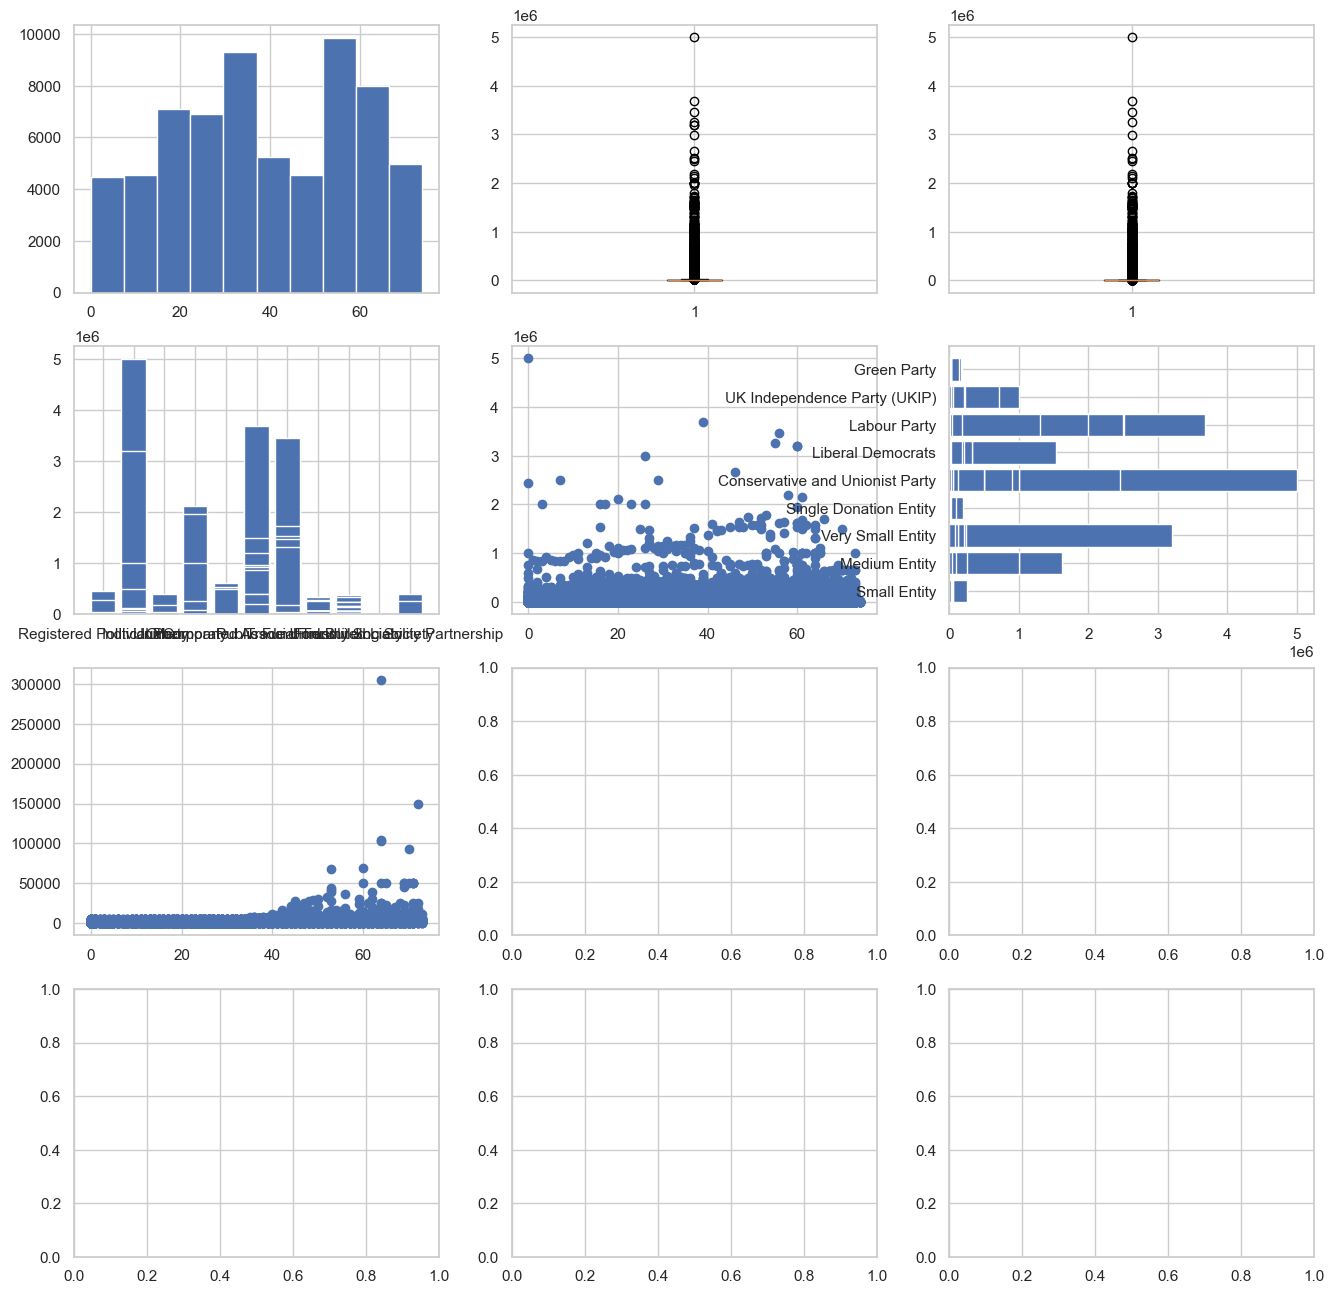

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,16))

axes[0,0].hist(df["QtrsSinceLastElection"])
axes[0,1].boxplot(x=df['Value'] )
axes[0,2].boxplot(data=df[df['RegulatedEntityType']=='Political Party'], x='Value')
# axes[1,0].scatter(x=df['YearMonthReceived'], y =df['Value'])
# axes[1,1].scatter(x=df['MonthReceived'], y=df['Value'])
axes[1,0].bar(x=df['DonorStatus'], height=df['Value'])
# axes[2,0].scatter(x=df['QtrsToNextElection'], y=df['Value'])
axes[1,1].scatter(x=df['QtrsSinceLastElection'], y=df['Value'])
axes[1,2].barh(y=df['RegEntity_Group'], width = df['Value'])
# axes[3,0].scatter(data=df[df['IsAggregation']==True], x='QtrsToNextElection', y='Value')
axes[2,0].scatter(data=df[df['IsAggregation']==True], x='QtrsSinceLastElection', y='Value')
# axes[4,0].scatter(data=df[df['IsAggregation']==False], x='QtrsToNextElection', y='Value')
# axes[2,1].scatter(data=df[df['IsAggregation']==False], x='QtrsSinceLastElection', y='Value')
# axes[2,2].hist(data=df[df['RegulatedEntityType']=='Political Party'], x='QtrsSinceLastElection')
# axes[3,0].scatter(data=df[df['RegulatedEntityType']=='Political Party'], x='QtrsSinceLastElection', y='Value')
plt.show()


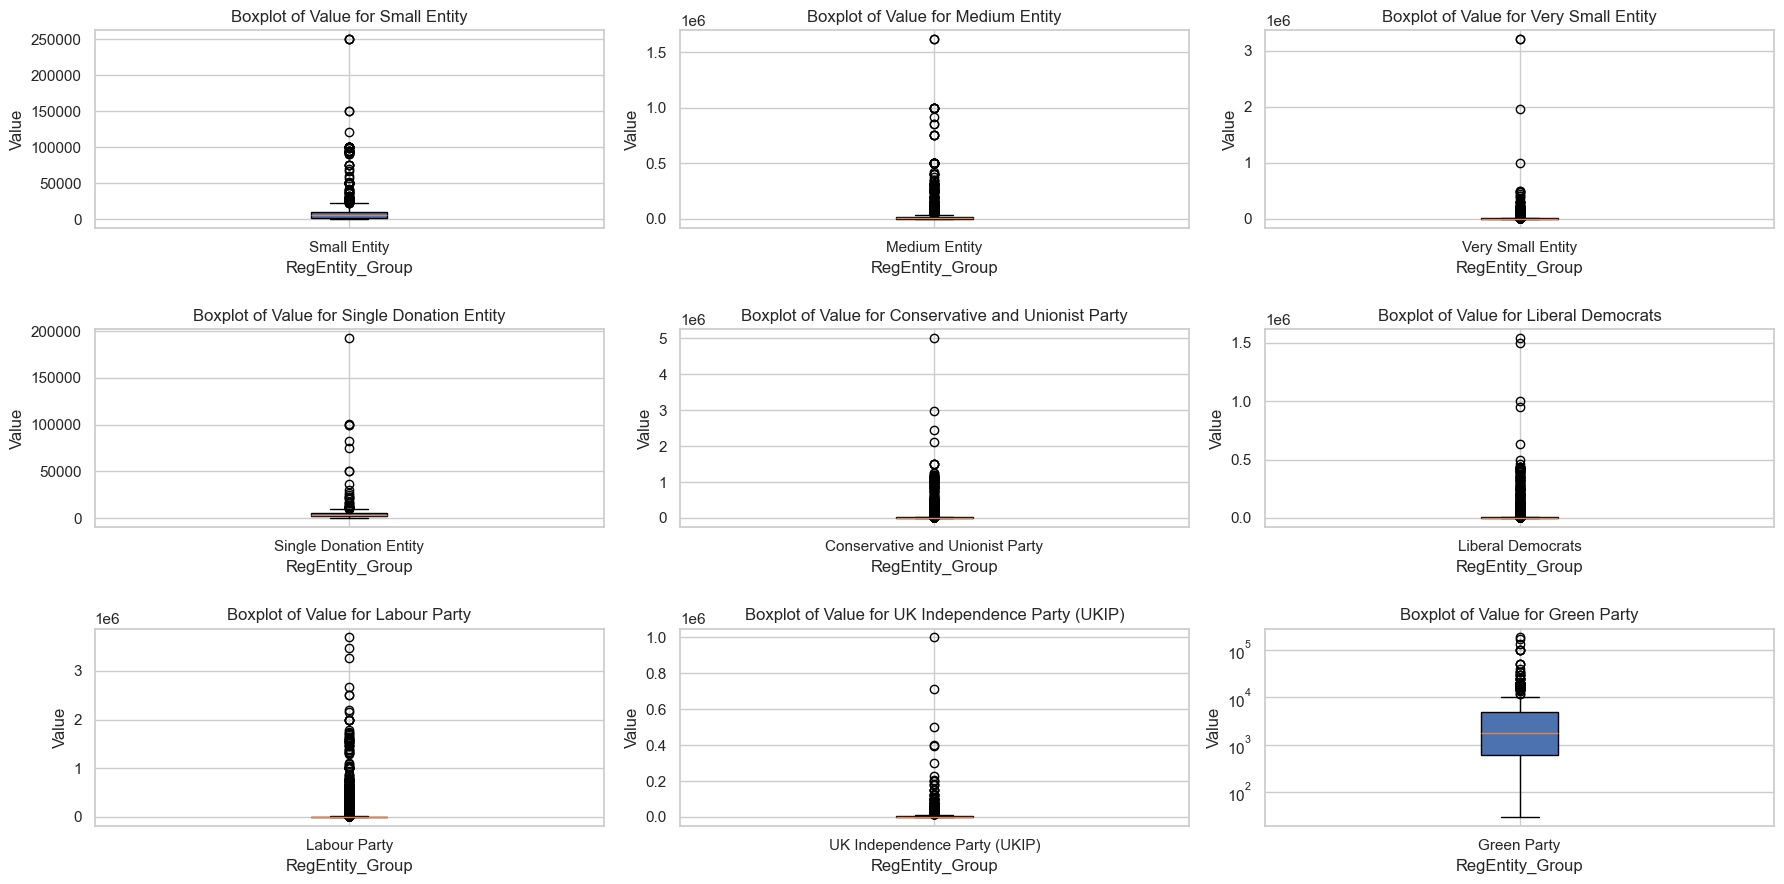

In [16]:
def generate_boxplots(df, column, value_column, plots_per_row=3, yscale='log'):
    """
    Generates boxplots for each unique value in the specified column of a dataframe.

    Parameters:
    - df: pandas DataFrame
    - column: str, the column to group by (e.g., 'RegEntity_Group')
    - value_column: str, the column to plot values for (e.g., 'Value')
    - plots_per_row: int, number of plots per row in the output
    - yscale: str, scale for the y-axis (e.g., 'log' or 'linear')
    
    Returns:
    - None (shows the plots)
    """
    unique_groups = df[column].unique()

    # Calculate the required number of rows
    num_rows = math.ceil(len(unique_groups) / plots_per_row)

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(18, 3 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    # Loop through each unique value in the column and corresponding axes
    for idx, group in enumerate(unique_groups):
        # Filter data for the current group
        group_data = df.loc[df[column] == group, value_column].dropna()

        # Create a boxplot for the current group
        axes[idx].boxplot(group_data, vert=True, patch_artist=True, labels=[group])

        # Add labels and title
        axes[idx].set_title(f'Boxplot of {value_column} for {group}')
        axes[idx].set_ylabel(value_column)
        axes[idx].set_xlabel(column)

    # Hide any unused axes
    for ax in axes[len(unique_groups):]:
        ax.set_visible(False)

    # Adjust layout and show plot
    plt.yscale(yscale)
    plt.tight_layout()
    plt.show()


generate_boxplots(df, column='RegEntity_Group', value_column='Value')

In [17]:
"""
Column	DataType	UniqueValues	RowsWithData	NullValues	SkewScore	Kurtosis
0	CompanyRegistrationNumber	string	3558	11480	53455	NaN	NaN
1	DonationAction	string	0	0	64935	NaN	NaN
12	Postcode	string	4557	35011	29924	NaN	NaN
14	RegulatedDoneeType	object	13	7061	57874	NaN	NaN
"""

# drop unrequired Columns
df = df.drop(['CompanyRegistrationNumber', 
            'DonationAction',
             'Postcode', 
             'RegulatedDoneeType',
             'ECRef', 
             'IsAggregation', 
             'IsBequest', 
             'IsSponsorship', 
             'ReportingPeriodName',
             'RegulatedEntityId',
             'RegulatedEntityName',
             'RegulatedEntityType',
             'DonorId'
             ], axis=1)



In [18]:
# DataSummary post clean
# list all non obect fields
NonObject = df.select_dtypes(exclude=['object', 'string', 'datetime64']).columns

summary_df2 = pd.DataFrame({
    'DataType': df.dtypes,
    'UniqueValues': df.nunique(),
    'RowsWithData': len(df)-df.isnull().sum(),
    'NullValues':df.isnull().sum(),
    'SkewScore':df[NonObject].skew(),
    'Kurtosis':df[NonObject].kurtosis()
}).reset_index().rename(columns={'index': 'Column'})
print(df.describe())
summary_df2

              Value                   ReceivedDate  DaysToNextElection  \
count  6.493500e+04                          64935        64935.000000   
mean   1.679346e+04  2010-12-06 09:44:36.257796096          626.230646   
min    0.000000e+00            2001-01-01 00:00:00            0.000000   
25%    1.550000e+03            2006-12-13 00:00:00          186.000000   
50%    3.000000e+03            2010-06-23 00:00:00          491.000000   
75%    9.000000e+03            2015-04-01 00:00:00          975.000000   
max    5.000000e+06            2019-09-02 00:00:00         1856.000000   
std    8.398893e+04                            NaN          510.426091   

       WeeksToNextElection  QtrsToNextElection  DaysSinceLastElection  \
count         64935.000000        64935.000000           64935.000000   
mean             89.913329            7.407931            3470.479680   
min               0.000000            0.000000               0.000000   
25%              27.000000            3.0

,Column,DataType,UniqueValues,RowsWithData,NullValues,SkewScore,Kurtosis
0,DaysSinceLastElection,int64,5945,64935,0,-0.110709,-1.121681
1,DaysToNextElection,int64,1845,64935,0,0.723396,-0.567946
2,DonationType,object,6,64935,0,NaN,NaN
3,DonorName,object,18787,64935,0,NaN,NaN
4,DonorStatus,object,11,64935,0,NaN,NaN
5,NatureOfDonation,object,33,64935,0,NaN,NaN
6,QtrsSinceLastElection,int64,75,64935,0,-0.115552,-1.114566
7,QtrsToNextElection,int64,22,64935,0,0.729141,-0.551337
8,ReceivedDate,datetime64[ns],6057,64935,0,NaN,NaN
9,RegEntity_Group,object,9,64935,0,NaN,NaN


In [19]:
"""
	Column	DataType	UniqueValues	RowsWithData	NullValues	SkewScore	Kurtosis
0	DonationType	object	6	64935	0	NaN	NaN
1	DonorId	object	44481	64935	0	0.631383	-0.530352
2	DonorName	object	18787	64935	0	NaN	NaN
3	DonorStatus	object	11	64935	0	NaN	NaN
4	ECRef	object	64935	64935	0	NaN	NaN
5	NatureOfDonation	object	33	64935	0	NaN	NaN
6	QtrsSinceLastElection	int64	22	64935	0	0.121860	-1.251056
7	ReceivedDate	datetime64[ns]	6057	64935	0	NaN	NaN
8	RegEntity_Group	object	20	64935	0	NaN	NaN
9	Value	float64	11210	64935	0	19.373063	604.980827
10	Value_Category	object	10	64935	0	NaN	NaN
* Variable Analyzed: Value
* Applied transformation: ['Value_power', 'Value_yeo_johnson'] 
  
"""
variables_engineering= ['DonationType',
    'DonorStatus',
    'NatureOfDonation',
    'RegEntity_Group', 
    'Value_Category'
    ]
df_engineering = df[variables_engineering].copy()
# 'numerical', 'ordinal_encoder',  'outlier_winsorizer'
df_engineering = FeatureEngineeringAnalysis(df=df_engineering.dropna(),analysis_type='ordinal_encoder')

NameError: name 'FeatureEngineeringAnalysis' is not defined

In [22]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64935 entries, 0 to 65277
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Value_Category         64935 non-null  object        
 1   Value                  64935 non-null  float64       
 2   DonorName              64935 non-null  object        
 3   DonorStatus            64935 non-null  object        
 4   DonationType           64935 non-null  object        
 5   NatureOfDonation       64935 non-null  object        
 6   ReceivedDate           64935 non-null  datetime64[ns]
 7   RegEntity_Group        64935 non-null  object        
 8   QtrsSinceLastElection  64935 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 7.0+ MB
None


,Value_Category,Value,DonorName,DonorStatus,DonationType,NatureOfDonation,ReceivedDate,RegEntity_Group,QtrsSinceLastElection
index,,,,,,,,,
0,"(1837.434, 2048.628]",1876.56,Conservative and Unionist Party,Registered Political Party,Non Cash,Staff costs,2019-09-02,Medium Entity,9
1,"(2048.628, 3000.0]",2700.00,Conservative and Unionist Party,Registered Political Party,Non Cash,Consultancy services,2019-09-02,Medium Entity,9
2,"(3000.0, 5000.0]",4852.58,Conservative and Unionist Party,Registered Political Party,Non Cash,Staff costs,2019-08-30,Medium Entity,9
3,"(2048.628, 3000.0]",2500.00,Conservative and Unionist Party,Registered Political Party,Non Cash,Staff costs,2019-08-30,Medium Entity,9
4,"(3000.0, 5000.0]",4524.05,Conservative and Unionist Party,Registered Political Party,Non Cash,Administration services,2019-08-29,Medium Entity,9


In [23]:
df.sort_values([ 'NatureOfDonation', 'DonorStatus', 'DonationType'])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 64935 entries, 0 to 65277
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Value_Category         64935 non-null  object        
 1   Value                  64935 non-null  float64       
 2   DonorName              64935 non-null  object        
 3   DonorStatus            64935 non-null  object        
 4   DonationType           64935 non-null  object        
 5   NatureOfDonation       64935 non-null  object        
 6   ReceivedDate           64935 non-null  datetime64[ns]
 7   RegEntity_Group        64935 non-null  object        
 8   QtrsSinceLastElection  64935 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 7.0+ MB


In [38]:
# Start to build machine learning model - to forcast Regulated Entity Group receiving payment 
#  based on donor(status, Type, Name, Donor Regulatory Status) qtrs since last election, value of donation, wether it was a bequest,
#  wether it was an aggregation, Nature Of Donation

le=LabelEncoder()
df['Value_Category_code'] = le.fit_transform(df['Value_Category'])
df['DonorName_code'] = le.fit_transform(df['DonorName'])
df['DonorStatus_code'] = le.fit_transform(df['DonorStatus'])
df['DonationType_code'] = le.fit_transform(df['DonationType'])
df['NatureOfDonation_code'] = le.fit_transform(df['NatureOfDonation'])
df['RegEntity_Group_code'] =  le.fit_transform(df['RegEntity_Group'])
df.head()

,Value_Category,Value,DonorName,DonorStatus,DonationType,NatureOfDonation,ReceivedDate,RegEntity_Group,QtrsSinceLastElection,Value_Category_code,DonorName_code,DonorStatus_code,DonationType_code,NatureOfDonation_code,RegEntity_Group_code,value_original
index,,,,,,,,,,,,,,,,
0,"(1837.434, 2048.628]",4.276550,Conservative and Unionist Party,Registered Political Party,Non Cash,Staff costs,2019-09-02,Medium Entity,9,3,6076,7,2,30,6,1876.56
1,"(2048.628, 3000.0]",4.376095,Conservative and Unionist Party,Registered Political Party,Non Cash,Consultancy services,2019-09-02,Medium Entity,9,4,6076,7,2,5,6,2700.00
2,"(3000.0, 5000.0]",4.524278,Conservative and Unionist Party,Registered Political Party,Non Cash,Staff costs,2019-08-30,Medium Entity,9,5,6076,7,2,30,6,4852.58
3,"(2048.628, 3000.0]",4.355540,Conservative and Unionist Party,Registered Political Party,Non Cash,Staff costs,2019-08-30,Medium Entity,9,4,6076,7,2,30,6,2500.00
4,"(3000.0, 5000.0]",4.507316,Conservative and Unionist Party,Registered Political Party,Non Cash,Administration services,2019-08-29,Medium Entity,9,5,6076,7,2,0,6,4524.05


In [25]:
#Apply YeoJohnsonTransformer to Value
df['value_original']=df['Value']

ytf = YeoJohnsonTransformer(variables = ['Value'])

ytf.fit(df)

ytf.lambda_dict_

df=ytf.transform(df)

In [26]:
df

,Value_Category,Value,DonorName,DonorStatus,DonationType,NatureOfDonation,ReceivedDate,RegEntity_Group,QtrsSinceLastElection,Value_Category_code,DonorName_code,DonorStatus_code,DonationType_code,NatureOfDonation_code,RegEntity_Group_code,value_original
index,,,,,,,,,,,,,,,,
0,"(1837.434, 2048.628]",4.276550,Conservative and Unionist Party,Registered Political Party,Non Cash,Staff costs,2019-09-02,Medium Entity,9,3,6076,7,2,30,6,1876.56
1,"(2048.628, 3000.0]",4.376095,Conservative and Unionist Party,Registered Political Party,Non Cash,Consultancy services,2019-09-02,Medium Entity,9,4,6076,7,2,5,6,2700.00
2,"(3000.0, 5000.0]",4.524278,Conservative and Unionist Party,Registered Political Party,Non Cash,Staff costs,2019-08-30,Medium Entity,9,5,6076,7,2,30,6,4852.58
3,"(2048.628, 3000.0]",4.355540,Conservative and Unionist Party,Registered Political Party,Non Cash,Staff costs,2019-08-30,Medium Entity,9,4,6076,7,2,30,6,2500.00
4,"(3000.0, 5000.0]",4.507316,Conservative and Unionist Party,Registered Political Party,Non Cash,Administration services,2019-08-29,Medium Entity,9,5,6076,7,2,0,6,4524.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65273,"(6360.086, 10000.0]",4.688084,Shaftesbury Investments,Company,Cash,Other,2016-04-04,Vote Leave Limited,4,7,17068,1,0,25,19,10000.00
65274,"(25000.0, 5000000.0]",5.095059,Mr Jeremy Hosking,Individual,Cash,Other,2016-02-08,Vote Leave Limited,3,9,11573,3,0,25,19,100000.00
65275,"(25000.0, 5000000.0]",4.951643,Anthony Clarke,Individual,Cash,Other,2016-06-17,Vote Leave Limited,4,9,332,3,0,25,19,40000.00


In [27]:
X_train, X_test, y_train, y_test =  train_test_split(
            df.drop(labels=["RegEntity_Group_code","value_original","RegEntity_Group","Value_Category",  "DonorName", "DonorStatus", "DonationType", "NatureOfDonation"], axis=1),
            df["RegEntity_Group_code"],
            test_size=0.3,
            random_state=0
            )

X_train.head()

,Value,ReceivedDate,QtrsSinceLastElection,Value_Category_code,DonorName_code,DonorStatus_code,DonationType_code,NatureOfDonation_code
index,,,,,,,,
11232,5.095059,2016-05-25,4,9,3438,3,0,25
49025,4.639635,2006-08-08,6,7,12077,3,0,25
28715,4.652978,2011-07-22,5,7,10395,3,0,25
20442,4.470736,2014-06-30,17,5,14238,3,0,25
47668,3.898070,2006-12-31,7,0,4975,10,2,27


In [28]:
X_test.head()

,Value,ReceivedDate,QtrsSinceLastElection,Value_Category_code,DonorName_code,DonorStatus_code,DonationType_code,NatureOfDonation_code
index,,,,,,,,
31322,3.945532,2010-08-16,1,0,7096,8,0,2
61671,4.558004,2002-02-15,3,6,6319,6,4,28
57939,4.267116,2003-12-31,11,2,5881,3,0,25
6965,4.531459,2017-04-25,8,5,14262,3,0,25
1640,4.531459,2019-01-15,7,5,5245,1,0,25


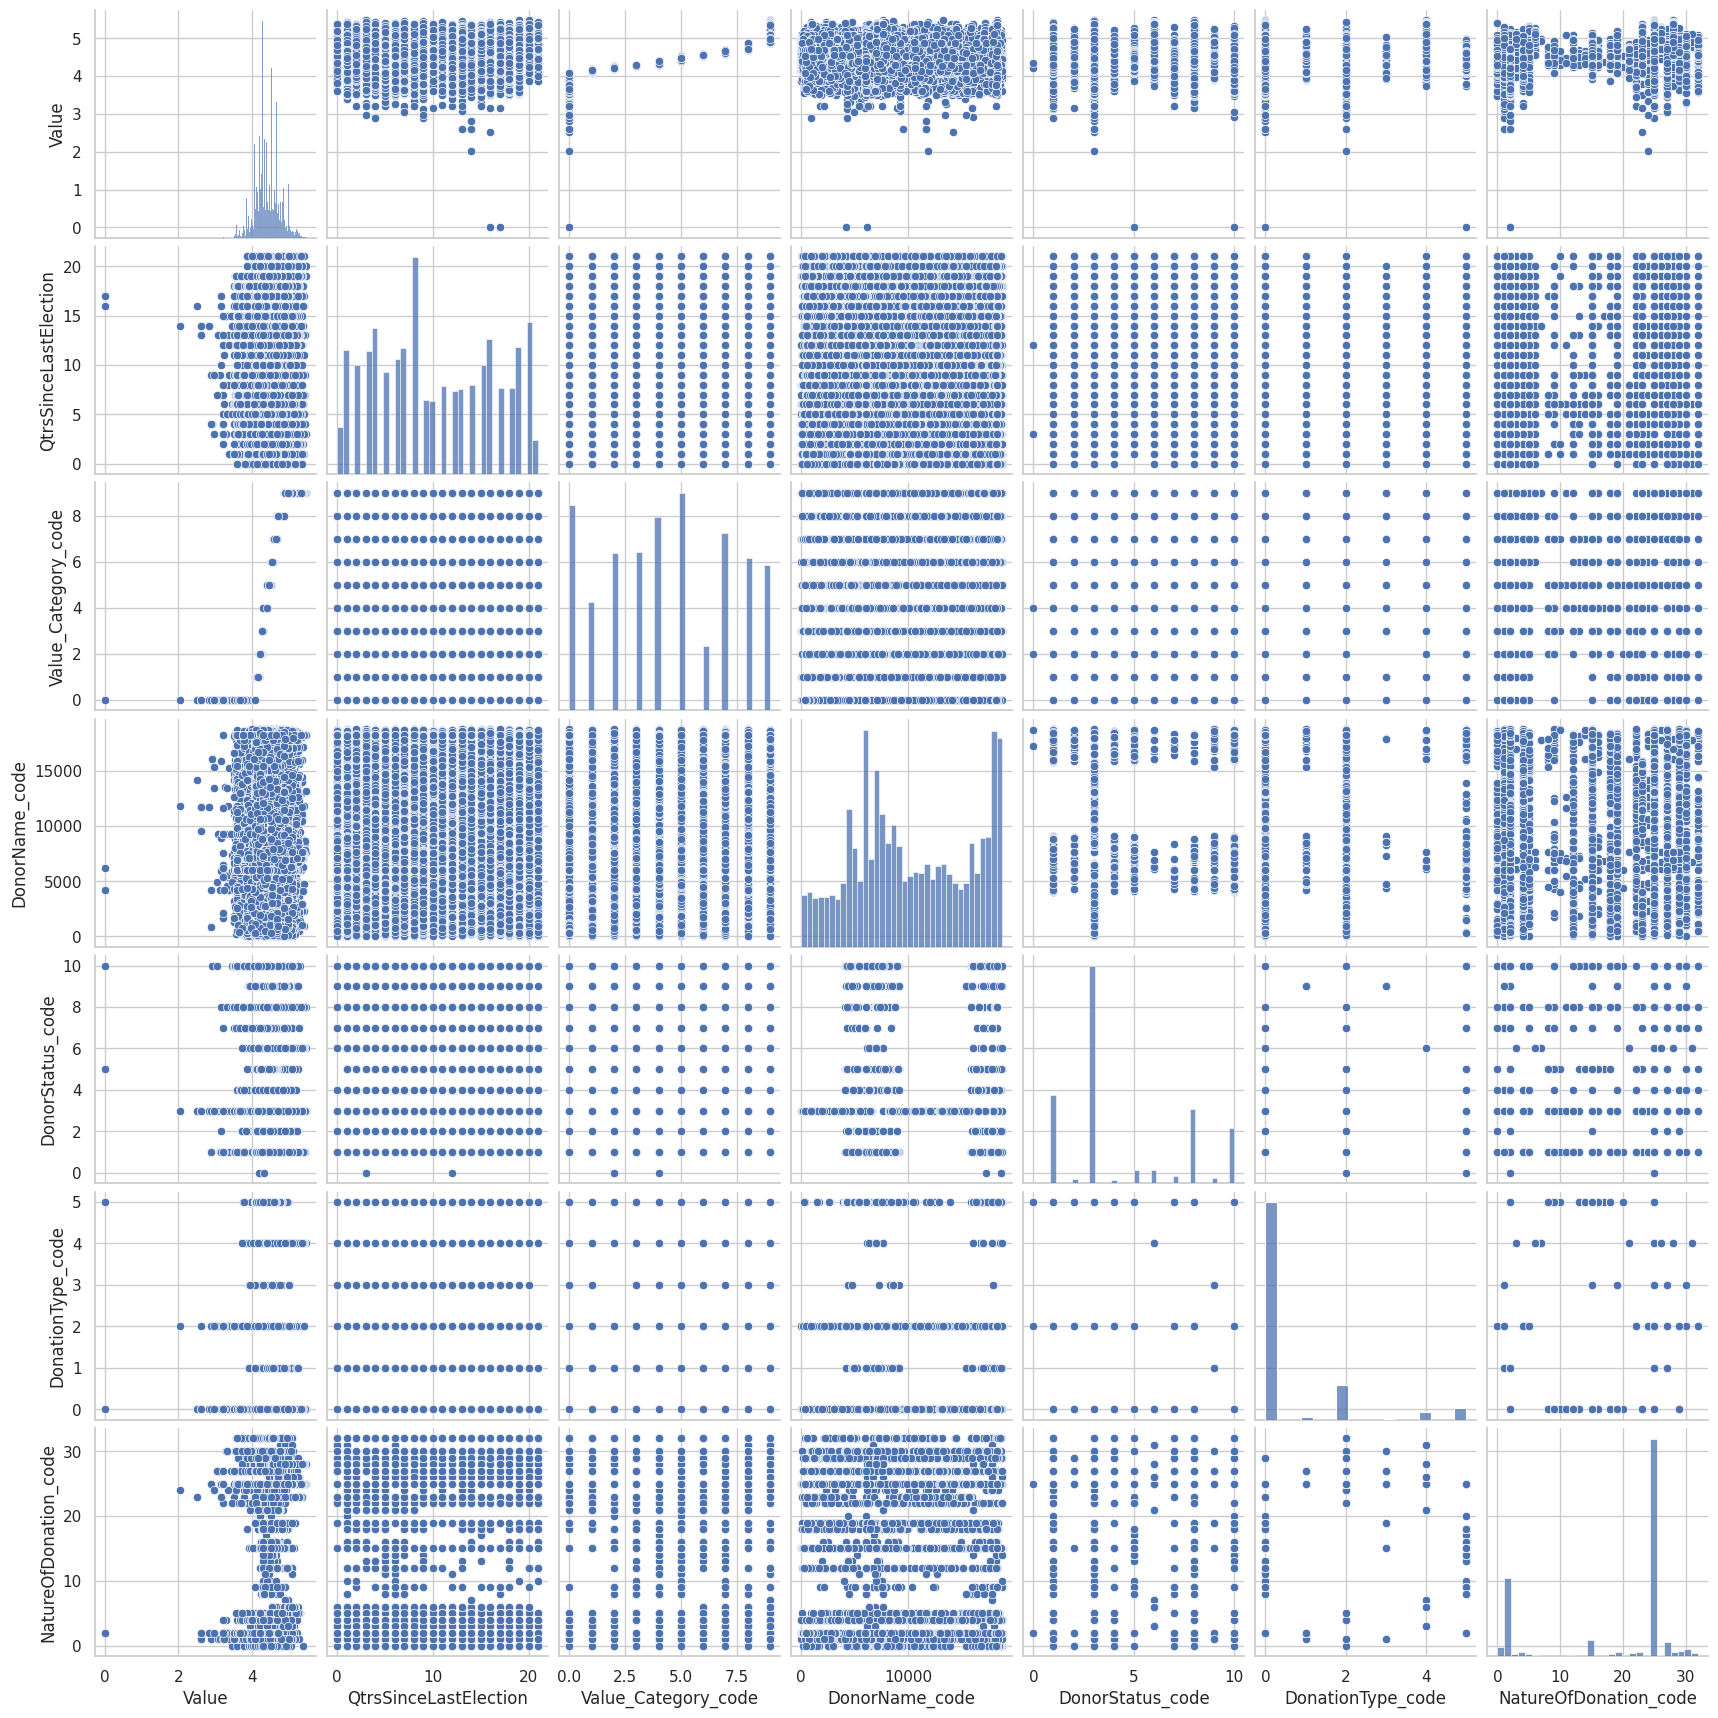

In [29]:
sns.pairplot(data=X_train)
plt.show()

In [30]:
model_data = df

# Create Target Object Y
y= model_data['RegEntity_Group_code']

features = ['Value', 'QtrsSinceLastElection', 'Value_Category_code', 'DonorName_code', 'DonorStatus_code', 'DonationType_code','NatureOfDonation_code']

X = model_data[features]
# split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)


# Specify Model
DonationRecipient = DecisionTreeRegressor()
# Fit Model
DonationRecipient.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = DonationRecipient.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {}".format(val_mae))

# Using best value for max_leaf_nodes
DonationRecipient = DecisionTreeRegressor(max_leaf_nodes=100000, random_state=1)
DonationRecipient.fit(train_X, train_y)
val_predictions = DonationRecipient.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {}".format(val_mae))



Validation MAE when not specifying max_leaf_nodes: 1.6082401051132256
Validation MAE for best value of max_leaf_nodes: 1.6345671260041246


In [31]:
train_X.describe()


,Value,QtrsSinceLastElection,Value_Category_code,DonorName_code,DonorStatus_code,DonationType_code,NatureOfDonation_code
count,48701.000000,48701.000000,48701.000000,48701.000000,48701.000000,48701.000000,48701.000000
mean,4.432419,10.215519,4.364305,10284.204287,4.460196,0.577154,18.823392
std,0.330733,6.179857,2.867829,5380.538527,3.002080,1.280700,10.174522
min,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.221759,5.000000,2.000000,6021.000000,3.000000,0.000000,5.000000
50%,4.403810,9.000000,4.000000,9480.000000,3.000000,0.000000,25.000000
75%,4.665434,16.000000,7.000000,15502.000000,8.000000,0.000000,25.000000
max,5.510335,21.000000,9.000000,18786.000000,10.000000,5.000000,32.000000


In [32]:
val_X.describe()

,Value,QtrsSinceLastElection,Value_Category_code,DonorName_code,DonorStatus_code,DonationType_code,NatureOfDonation_code
count,16234.000000,16234.000000,16234.000000,16234.000000,16234.000000,16234.000000,16234.000000
mean,4.434451,10.170691,4.375262,10300.934951,4.421400,0.585623,18.815572
std,0.323790,6.178130,2.862180,5372.749821,3.003091,1.285028,10.180130
min,2.969490,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,4.223583,5.000000,2.000000,6021.000000,3.000000,0.000000,5.000000
50%,4.403810,9.000000,4.000000,9473.000000,3.000000,0.000000,25.000000
75%,4.673379,16.000000,7.000000,15646.750000,8.000000,0.000000,25.000000
max,5.470028,21.000000,9.000000,18782.000000,10.000000,5.000000,32.000000


In [33]:
train_y.describe()

count    48701.000000
mean         5.445227
std          4.644537
min          0.000000
25%          2.000000
50%          4.000000
75%          5.000000
max         19.000000
Name: RegEntity_Group_code, dtype: float64

In [34]:
val_y.describe()

count    16234.000000
mean         5.457805
std          4.648619
min          0.000000
25%          2.000000
50%          4.000000
75%          5.000000
max         19.000000
Name: RegEntity_Group_code, dtype: float64

In [35]:
# Define the model. Set random_state to 1
rf_model = RandomForestRegressor(random_state=1)

# fit your model
rf_model.fit(train_X, train_y)
rf_preds = rf_model.predict(val_X)
# Calculate the mean absolute error of your Random Forest model on the validation data
rf_val_mae = mean_absolute_error(val_y, rf_preds)

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))


Validation MAE for Random Forest Model: 1.5463935670109583


In [36]:
train_y

index
26926     2
22844    17
51723     4
17431     2
15800     6
         ..
32513     4
5192      2
12172     2
33005     4
62503    18
Name: RegEntity_Group_code, Length: 48701, dtype: int64

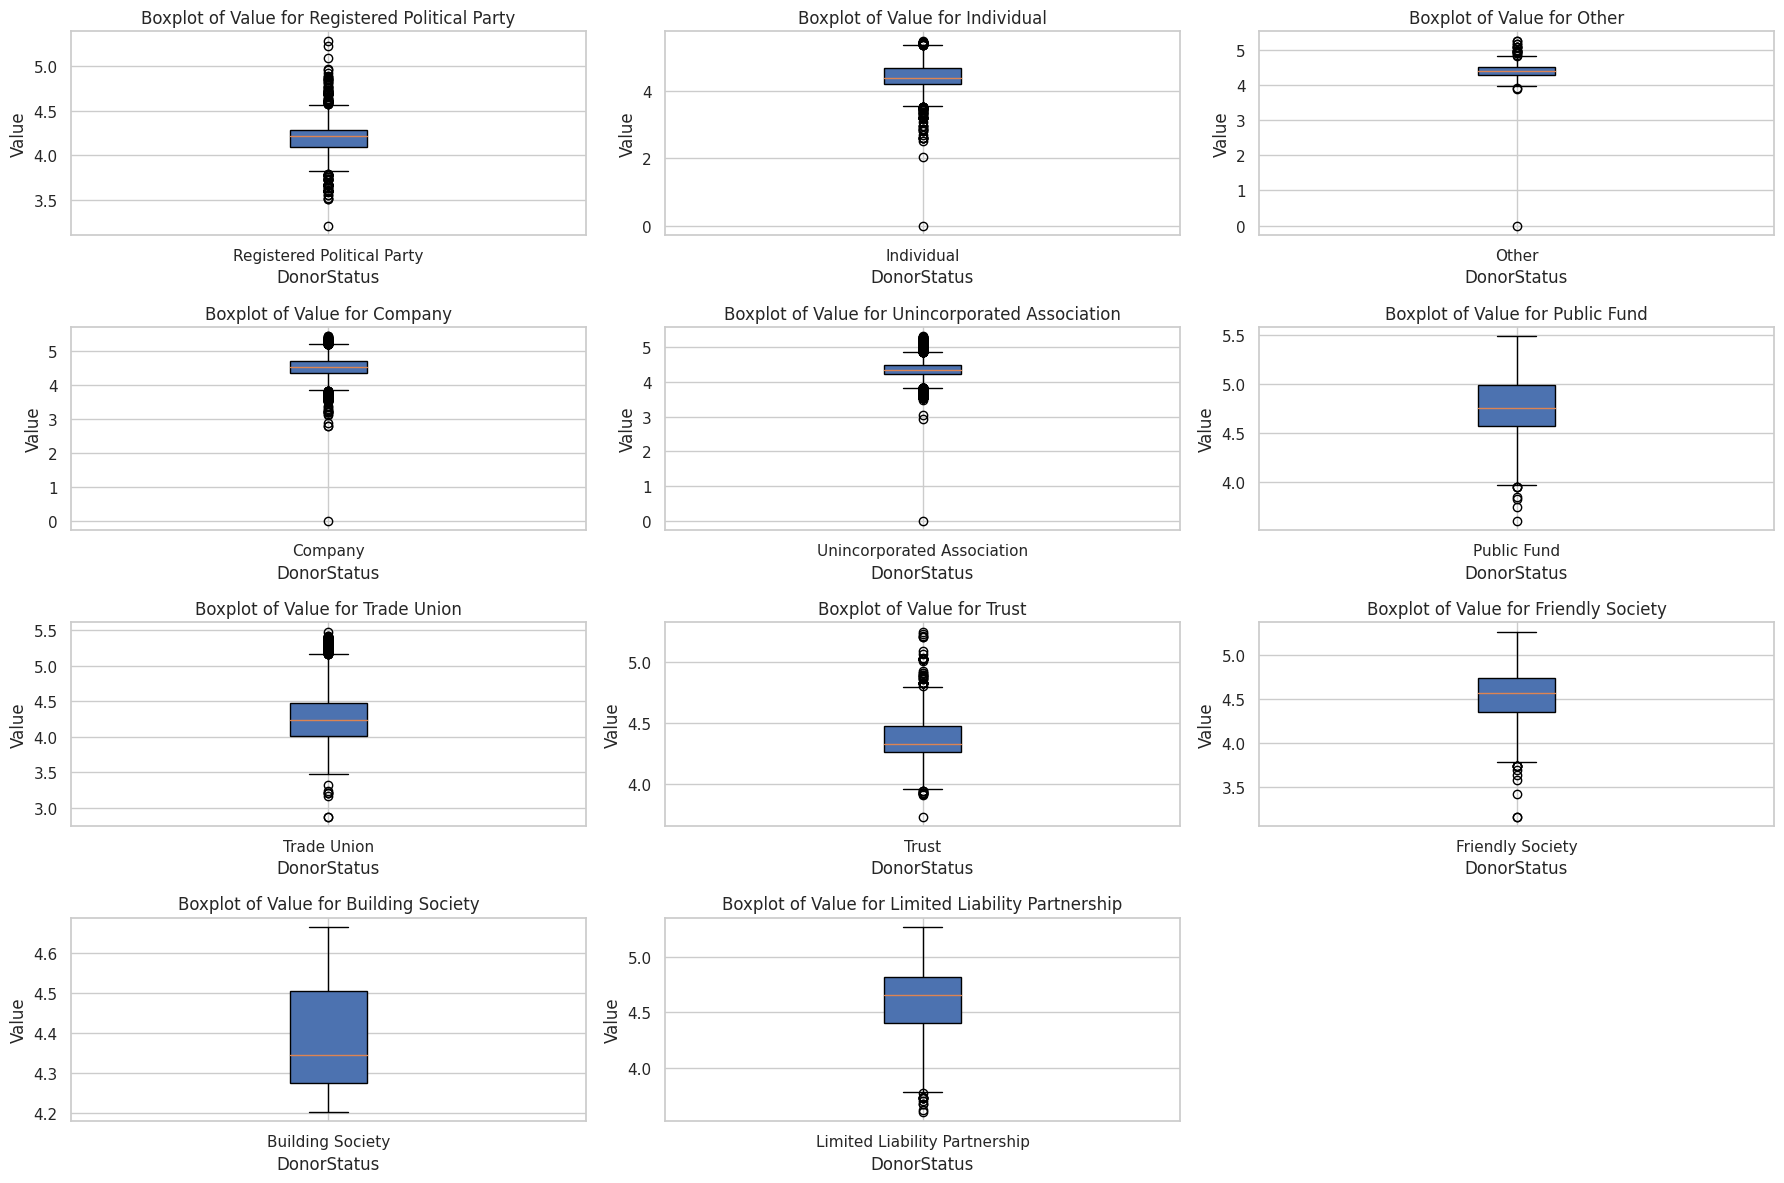

In [37]:
# Get unique values in DonorStatus
unique_groups = df['DonorStatus'].unique()

# Number of plots per row
plots_per_row = 3

# Calculate the required number of rows
num_rows = math.ceil(len(unique_groups) / plots_per_row)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(18, 3 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each unique value in DonorStatus and corresponding axes
for idx, group in enumerate(unique_groups):
    # Filter data for the current group
    group_data = df.loc[df['DonorStatus'] == group, 'Value'].dropna()
    
    # Create a boxplot for the current group
    axes[idx].boxplot(group_data, vert=True, patch_artist=True, labels=[group])
    
    # Add labels and title
    axes[idx].set_title(f'Boxplot of Value for {group}')
    axes[idx].set_ylabel('Value')
    axes[idx].set_xlabel('DonorStatus')

# Hide any unused axes
for ax in axes[len(unique_groups):]:
    ax.set_visible(False)

# Adjust layout and show plot
plt.yscale('log')
plt.tight_layout()
plt.show()